In [22]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
import zipfile
from IPython import display
import os
import cv2
from matplotlib import image
from skimage.color import rgb2gray

In [23]:
#### HYPER PARAMETERS
BATCH_SIZE = 50
EPOCHS = 100
noise_dim = 100
BUFFER_SIZE = 60000
WIDTH=128 # 128
HEIGHT=128 # 128

# Name of dataset zip file without .zip extension
Dataset = "CT_COVID"

# to visualize progress in the animated GIF)
seed = tf.random.normal([1, noise_dim])

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
filepath = "/content/drive/My Drive/Colab Notebooks/COVID19-GAN"
os.system("mkdir -p \"/content/drive/My Drive/Colab Notebooks/COVID_GAN_Saved_Models\"")
destination = "/drive/Data"
save_destination = "/content/drive/My Drive/Colab Notebooks/COVID_GAN_Saved_Models"

# Will unzip the files so that you can see them..
print(filepath)
with zipfile.ZipFile(filepath+"/"+Dataset+".zip","r") as z:
    z.extractall(destination)

/content/drive/My Drive/Colab Notebooks/COVID19-GAN


In [26]:
os.chdir(destination + "/" + Dataset)

path = "*.*"
data = []
for file in glob.glob(path):
  if(file.find("image_at_epoch") == -1):
    img_data = image.imread(file, 0)
    data.append(img_data)  
data = np.array(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [27]:
standardized_data = []
for img in data:
  img = rgb2gray(img)
  img2 = np.flip(img, axis=1) ## ADD FLIPPED IMAGE FOR LARGER DATA SET
  standardized_data.append(cv2.resize(img, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
  standardized_data.append(cv2.resize(img2, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
train_images = np.array(standardized_data)
train_images = train_images.reshape(train_images.shape[0],128,128,1).astype('float32')
print(train_images.shape)

(698, 128, 128, 1)


0

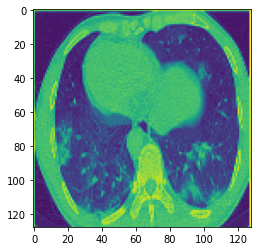

In [28]:
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
checker = train_images # np.reshape(train_images, (2164,28,28))
plt.imshow(checker[5,:,:,0])

os.system("rm -r \""+destination+"\"")

In [29]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 1)

    model.add(layers.Flatten())
    model.add(layers.Dense(128*128, use_bias=False, activation = 'tanh'))
    model.add(layers.Reshape((128,128,1)))
    print(model.output_shape)

    return model

In [30]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 4, 4, 1024)
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64))
    model.add(layers.Dense(32))
    model.add(layers.Dense(16))
    model.add(layers.Dense(1, activation="sigmoid"))

    opt = tf.keras.optimizers.Adam(1e-4)
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [31]:
def make_gan(g_model, d_model):
  d_model.trainable = False
  model = tf.keras.Sequential()
  model.add(g_model)
  model.add(d_model)

  opt = tf.keras.optimizers.Adam(1e-4)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [32]:
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X,y

In [33]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim*n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [34]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples, 1))
  return X,y

In [35]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size):
  genLoss = 0
  discLoss = 0
  batch_per_epoch = int(dataset.shape[0]/batch_size)
  half_batch = int(batch_size/2)
  best_g_model = g_model
  best_genLoss = 10
  for epoch in range(n_epochs):
    start = time.time()
    for i in range(batch_per_epoch):
      X_real, y_real = generate_real_samples(dataset,half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

      discLoss = (d_loss1 + d_loss2)/2

      X_gan = generate_latent_points(latent_dim, batch_size)
      y_gan = np.ones((batch_size, 1))
      genLoss = gan_model.train_on_batch(X_gan, y_gan)
  
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(g_model,
                             epoch + 1,
                             seed)
    
    ### PERFORMANCE CHECK
    X_real, y_real = generate_real_samples(dataset, 100)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 100)
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    print("Disc Accuracy Real: %.5f, fake: %.5f" % (acc_real, acc_fake))
    print("genloss: {} discloss: {}".format(genLoss, discLoss))
    if (epoch > 2./3. * n_epochs):
      if (genLoss < best_genLoss and acc_real > 0.9 and acc_fake > 0.9):
        best_genLoss = genLoss
        best_g_model = g_model

    # Save the model every 100 epochs
    # if epoch%100 == 0:
    #   g_model.save(save_destination+"/generator_intermediate.h5")
    #   d_model.save(save_destination+"/discriminator_intermediate.h5")

    genloss.append(genLoss)
    discloss.append(discLoss)
    accReal.append(acc_real)
    accFake.append(acc_fake)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(g_model,
                           n_epochs,
                           seed)
  print("Training complete")
  return best_g_model

In [36]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

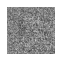

Disc Accuracy Real: 1.00000, fake: 1.00000
genloss: 1.7795406392906443e-06 discloss: 0.33961032963270554
Time for epoch 1 is 358.9245958328247 sec


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-be2d9009ee29>", line 8, in <module>
    generator = train(g_model, d_model, gan_model, train_images, noise_dim, EPOCHS, BATCH_SIZE)
  File "<ipython-input-35-5642989e55b2>", line 12, in train
    d_loss1, _ = d_model.train_on_batch(X_real, y_real)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 1727, in train_on_batch
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.7/di

KeyboardInterrupt: ignored

In [37]:
genloss = []
discloss = []
accReal = []
accFake = []
d_model = make_discriminator_model()
g_model = make_generator_model()
gan_model = make_gan(g_model, d_model)
generator = train(g_model, d_model, gan_model, train_images, noise_dim, EPOCHS, BATCH_SIZE)

g_model.save(save_destination+"/generator_final_02.h5")
d_model.save(save_destination+"/discriminator_final_02.h5")
gan_model.save(save_destination+"/gan_final_02.h5")

In [ ]:
plt.plot(range(EPOCHS), discloss, label='disc loss')
plt.plot(range(EPOCHS), genloss, label='gen loss')
plt.xlabel('Epoch')
# plt.ylim(-1,20)
plt.ylabel('Loss value') 
plt.legend()
plt.show()

In [ ]:
plt.plot(range(EPOCHS), accReal, label='accuracy Real')
plt.plot(range(EPOCHS), accFake, label='accuracy Fake')
plt.xlabel('Epoch')
plt.ylim(0,1.1)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.figure()
noise = np.random.randn(noise_dim)
noise = noise.reshape(1, noise_dim)
generated_image0 = generator.predict(noise)
plt.imshow(generated_image0[0, :, :, 0], cmap='gray')

f = plt.figure()
for i in range(1,26):
  f.add_subplot(5,5, i)
  noise = np.random.randn(noise_dim)
  noise = noise.reshape(1, noise_dim)
  generated_image0 = generator.predict(noise)
  plt.imshow(generated_image0[0, :, :, 0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()